# Protein Interaction Dashboard with cuxfilter and dask_cudf

## Import dask_cuda, dask

In [ ]:
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

client = Client(LocalCUDACluster())

### Display total available GPU resources

In [2]:
gpu_info = client.cluster.scheduler_info['workers'].values()

print(f"Total GPUs: {len(gpu_info)}\n")
for gpu in gpu_info:
    mem = f"{gpu['memory_limit']/(1024 **3):.2f} GB"
    gpu_mem = f"{gpu['gpu']['memory-total']/(1024 **3):.2f} GB"
    gpu_name = gpu['gpu']['name']
    print(f"{gpu_name}:\n\tMemory assigned: {mem}, Total Memory: {gpu_mem}")

Total GPUs: 2

NVIDIA TITAN RTX:
	Memory assigned: 15.63 GB, Total Memory: 24.00 GB
Quadro GV100:
	Memory assigned: 15.63 GB, Total Memory: 32.00 GB


## Import cuxfilter

In [ ]:
import cuxfilter
import dask_cudf
import cugraph
import numpy as np, pandas as pd

ITERATIONS=500
THETA=1.0
OPTIMIZE=True

## Load required datasets using dask_cudf

Using `dask_cudf.DataFrame.persist()` before passing it to cuxfilter.DataFrame turns a lazy Dask collection into a Dask collection with the same metadata, but now with the results fully computed or actively computing in the background. 

Passing a `dask_cudf.DataFrame` without `persist()` is also supported.

In [ ]:
edges = dask_cudf.read_csv('../data/edges.csv', usecols=['Source','Destination', 'edgeColor']).persist()
nodes = dask_cudf.read_csv('../data/nodes.csv', usecols=['x', 'y', 'SYMBOL', 'Color']).persist()
nodes.Color = nodes.Color - nodes.Color.min()

In [5]:
nodes

,x,y,SYMBOL,Color
npartitions=1,,,,
,float64,float64,int64,int64
,...,...,...,...


In [6]:
edges

,Source,Destination,edgeColor
npartitions=1,,,
,int64,int64,int64
,...,...,...


## preprocess the data

In [ ]:
edges.columns=["source", "destination", 'color']

G = cugraph.Graph()
G.from_cudf_edgelist(edges)

nodes_ = dask_cudf.from_cudf(cugraph.layout.force_atlas2(G, max_iter=500,
                strong_gravity_mode=False,
                outbound_attraction_distribution=True,
                lin_log_mode=False,
                barnes_hut_optimize=OPTIMIZE, barnes_hut_theta=THETA, verbose=True), npartitions=2)

In [ ]:
nodes_1 = nodes_.merge(nodes, left_on='vertex', right_on='SYMBOL', suffixes=('', '_y'))[list(nodes.columns)]

In [9]:
nodes_1

,x,y,SYMBOL,Color
npartitions=2,,,,
,float32,float32,int64,int64
,...,...,...,...
,...,...,...,...


## Define charts

In [ ]:
cux_df = cuxfilter.DataFrame.load_graph((nodes_1, edges))

In [ ]:
chart0 = cuxfilter.charts.graph(edge_target='destination',edge_color_palette=['gray', 'black'], 
                                            node_id='SYMBOL', timeout=200, edge_aggregate_col='color',
                                            node_aggregate_col='Color', node_aggregate_fn='mean', node_pixel_shade_type='linear',
                                            edge_render_type='direct',#other option available -> 'curved'
                                            edge_transparency=0.5, edge_color_palett=["black", "gray", "pink"], unselected_alpha=0.2
                                          )

chart1 = cuxfilter.charts.bar(x='Color', data_points=10)

## Create a dashboard object

In [ ]:
d = cux_df.dashboard([chart0, chart1], layout=cuxfilter.layouts.double_feature)

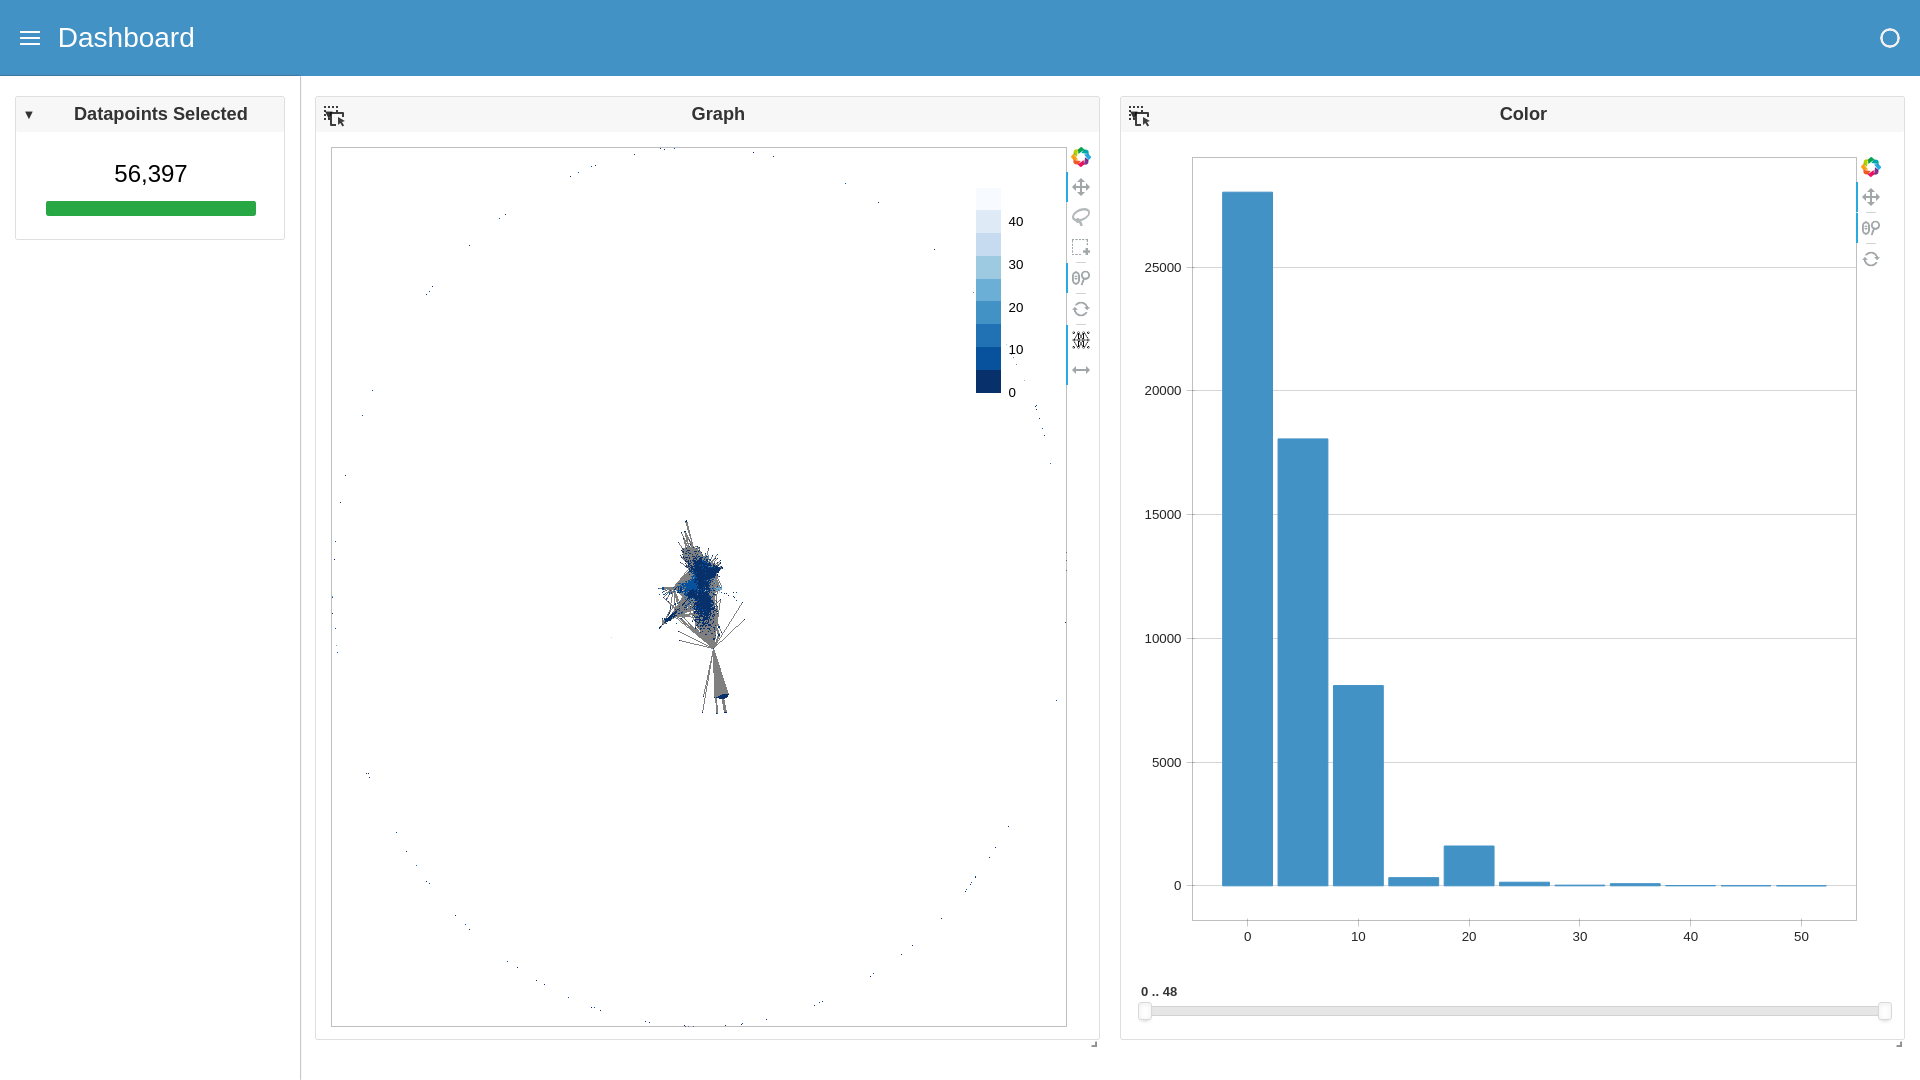

In [14]:
#execute below line for dashboard preview
# await d.preview()

## Starting the dashboard

1. d.show('current_notebook_url:current_notebook_port') remote dashboard

2. d.app() inline within the notebook cell

Incase you need to stop the server:

- d.stop()

In [ ]:
# d.show() # notebook_url="http://localhost:8888"
# d.app() # run the dashboard within the notebook cell

## Export the queried data into a dataframe

In [ ]:
queried_df = d.export()